In [184]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import f1_score, classification_report
from matplotlib import pyplot as plt

In [185]:
df = pd.read_csv(r'data\Student Depression Dataset.csv')
df

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1


In [186]:
target_var = ['Depression']

# Категориальные переменные и их веса (влияние на депрессию)
categorical_values = {
    'Sleep Duration': 0.8 / 4.9,  # Увеличено влияние (недосып сильно коррелирует с депрессией)
    'Dietary Habits': 0.4 /4.9  # Сбалансировано (диета имеет умеренное влияние)
}

# Числовые переменные (чем больше, тем лучше - прямые факторы)
numeric_values_inv = {
    'Study Satisfaction': 0.6 / 4.9,  # Снижено (влияет, но не так сильно как сон)
    'Job Satisfaction': 0.7 / 4.9     # Оставлено высоким (удовлетворенность работой важна)
}

# Числовые переменные (чем меньше, тем лучше - факторы стресса)
numeric_values = {
    'Academic Pressure': 0.7 / 4.9,    # Увеличено (академический стресс - ключевой фактор)
    'Work Pressure': 0.6 / 4.9,        # Оставлено значимым
    'Work/Study Hours': 0.3 / 4.9,     # Снижено (длительность менее важна, чем интенсивность)
    'Financial Stress': 0.8 / 4.9     # Увеличено (финансовый стресс - один из главных факторов)
}

# Максимальные значения для нормализации
numeric_values_max = df[numeric_values.keys()].max() * 1.2
numeric_values_inv_max = df[numeric_values_inv.keys()].max() * 1.2

# Фаззификация категориальных переменных (обновлённые значения)
sleep_duration_defuzz = {
    'Less than 5 hours': 0.9,  # Сильное влияние на депрессию
    '5-6 hours': 0.6,
    '7-8 hours': 0.1,          # Оптимальный диапазон
    'More than 8 hours': 0.4,   # Избыток сна тоже может быть вреден
    'Others': 0.7
}

dietary_habits_defuzz = {
    'Healthy': 0.1,     # Здоровая диета снижает риск
    'Unhealthy': 0.85,  # Неправильное питание сильно влияет
    'Moderate': 0.3,
    'Others': 0.5
}

categorical_values_defuzz = {
    'Sleep Duration': sleep_duration_defuzz,
    'Dietary Habits': dietary_habits_defuzz
}

# Собираем все независимые переменные
independent_vars = list(categorical_values.keys()) + list(numeric_values.keys()) + list(numeric_values_inv.keys())
independent_vars_weights = categorical_values | numeric_values | numeric_values_inv

In [187]:
df = df[
    independent_vars + target_var
    ]
df.loc[:, numeric_values.keys()] = df[numeric_values.keys()] / numeric_values_max
df.loc[:, numeric_values_inv.keys()] = 1 - df[numeric_values_inv.keys()] / numeric_values_inv_max

for col, mapping in categorical_values_defuzz.items():
    df.loc[:, col] = df[col].map(mapping)

df

,Sleep Duration,Dietary Habits,Academic Pressure,Work Pressure,Work/Study Hours,Financial Stress,Study Satisfaction,Job Satisfaction,Depression
0,0.6,0.1,0.833333,0.0,0.208333,0.166667,0.666667,1.0,1
1,0.6,0.3,0.333333,0.0,0.208333,0.333333,0.166667,1.0,0
2,0.9,0.1,0.500000,0.0,0.625000,0.166667,0.166667,1.0,0
3,0.1,0.3,0.500000,0.0,0.277778,0.833333,0.666667,1.0,1
4,0.6,0.3,0.666667,0.0,0.069444,0.166667,0.500000,1.0,0
...,...,...,...,...,...,...,...,...,...
27896,0.6,0.85,0.833333,0.0,0.486111,0.166667,0.166667,1.0,0
27897,0.9,0.1,0.333333,0.0,0.000000,0.500000,0.500000,1.0,0
27898,0.6,0.85,0.500000,0.0,0.833333,0.333333,0.333333,1.0,0
27899,0.9,0.1,0.833333,0.0,0.694444,0.833333,0.666667,1.0,1


In [188]:
def sugeno_integral(values, weights):
    """
    Вычисляет интеграл Сугено для заданных значений и весов.

    Параметры:
    - values: список значений функции (f(x1), f(x2), ..., f(xn))
    - weights: список мер (g({x1}), g({x2}), ..., g({xn})), определяющих важность.

    Возвращает:
    - Значение интеграла Сугено.
    """
    if len(values) != len(weights):
        raise ValueError("values и weights должны быть одинаковой длины")

    # Сортируем по значениям по убыванию
    paired = sorted(zip(values, weights), key=lambda x: -x[0])
    sorted_values, weights_sorted = zip(*paired)

    # Кумулятивная сумма весов от конца (сумма весов критериев с оценкой >= текущей)
    cum_weights = np.cumsum(weights_sorted)[::-1]

    # Находим минимум между каждым значением и соответствующей суммой весов
    mins = np.minimum(sorted_values[::-1], cum_weights)

    # Интеграл Сугено – максимальный из полученных минимумов
    return np.max(mins)

In [189]:
integral_values = list()
cols, weights = zip(*independent_vars_weights.items())
df_sugeno = df.loc[:, list(cols)]
df['SugenoIntegral'] = df_sugeno.apply(lambda row: sugeno_integral(row, weights), axis=1)
df

C:\Users\vikto\AppData\Local\Temp\ipykernel_8168\745399684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SugenoIntegral'] = df_sugeno.apply(lambda row: sugeno_integral(row, weights), axis=1)


,Sleep Duration,Dietary Habits,Academic Pressure,Work Pressure,Work/Study Hours,Financial Stress,Study Satisfaction,Job Satisfaction,Depression,SugenoIntegral
0,0.6,0.1,0.833333,0.0,0.208333,0.166667,0.666667,1.0,1,0.571429
1,0.6,0.3,0.333333,0.0,0.208333,0.333333,0.166667,1.0,0,0.333333
2,0.9,0.1,0.500000,0.0,0.625000,0.166667,0.166667,1.0,0,0.500000
3,0.1,0.3,0.500000,0.0,0.277778,0.833333,0.666667,1.0,1,0.500000
4,0.6,0.3,0.666667,0.0,0.069444,0.166667,0.500000,1.0,0,0.500000
...,...,...,...,...,...,...,...,...,...,...
27896,0.6,0.85,0.833333,0.0,0.486111,0.166667,0.166667,1.0,0,0.530612
27897,0.9,0.1,0.333333,0.0,0.000000,0.500000,0.500000,1.0,0,0.500000
27898,0.6,0.85,0.500000,0.0,0.833333,0.333333,0.333333,1.0,0,0.500000
27899,0.9,0.1,0.833333,0.0,0.694444,0.833333,0.666667,1.0,1,0.673469


In [190]:
df.sort_values(by='SugenoIntegral', ascending=False).head(20)

,Sleep Duration,Dietary Habits,Academic Pressure,Work Pressure,Work/Study Hours,Financial Stress,Study Satisfaction,Job Satisfaction,Depression,SugenoIntegral
23758,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
26897,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
13770,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
19527,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
3630,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
12015,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
21715,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
11723,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
8318,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333
15548,0.9,0.85,0.833333,0.0,0.833333,0.833333,0.833333,1.0,1,0.833333


In [191]:
df.sort_values(by='SugenoIntegral', ascending=False).tail(20)

,Sleep Duration,Dietary Habits,Academic Pressure,Work Pressure,Work/Study Hours,Financial Stress,Study Satisfaction,Job Satisfaction,Depression,SugenoIntegral
4604,0.1,0.85,0.166667,0.0,0.000000,0.166667,0.166667,1.0,0,0.224490
12444,0.1,0.85,0.166667,0.0,0.000000,0.166667,0.166667,1.0,0,0.224490
25665,0.1,0.85,0.166667,0.0,0.000000,0.166667,0.166667,1.0,0,0.224490
17804,0.1,0.1,0.166667,0.0,0.625000,0.166667,0.166667,1.0,0,0.204082
15943,0.1,0.1,0.166667,0.0,0.277778,0.166667,0.166667,1.0,0,0.204082
21501,0.1,0.1,0.166667,0.0,0.625000,0.166667,0.166667,1.0,0,0.204082
7475,0.1,0.1,0.166667,0.0,0.486111,0.166667,0.166667,1.0,0,0.204082
5354,0.1,0.1,0.166667,0.0,0.347222,0.166667,0.166667,1.0,0,0.204082
1287,0.1,0.1,0.166667,0.0,0.833333,0.166667,0.166667,1.0,0,0.204082
3942,0.1,0.1,0.166667,0.0,0.625000,0.166667,0.166667,1.0,0,0.204082


In [192]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Depression', axis=1), df['Depression'], test_size=0.2, random_state=42)

In [193]:
def calculat_f1(threshold):
    preds = (X_train['SugenoIntegral'] > threshold[0]).astype(np.int32)
    return -f1_score(y_train, preds)

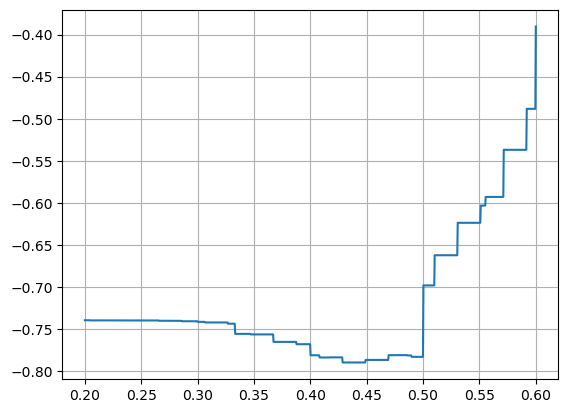

In [204]:
length = 1000

thresh_values = np.linspace(0.2, 0.6, length)[..., None]
f1_values = np.zeros(length)

for idx, thresh in enumerate(thresh_values):
    f1_values[idx] = calculat_f1(thresh)

plt.plot(thresh_values, f1_values)
plt.grid(True)

In [205]:
threshold = 0.44

In [206]:
df['SugenoIntegral'].describe()

count    27898.000000
mean         0.512397
std          0.095080
min          0.166667
25%          0.448980
50%          0.500000
75%          0.591837
max          0.833333
Name: SugenoIntegral, dtype: float64

In [207]:
y_train.describe()

count    22320.000000
mean         0.586828
std          0.492414
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Depression, dtype: float64

In [208]:
(df['SugenoIntegral'] > threshold).astype(np.int32).describe()

count    27901.000000
mean         0.785348
std          0.410588
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: SugenoIntegral, dtype: float64

In [209]:
y_pred_train = (X_train['SugenoIntegral'] > threshold).astype(np.int32)
y_pred_test = (X_test['SugenoIntegral'] > threshold).astype(np.int32)

In [210]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.79      0.41      0.54      9222
           1       0.69      0.92      0.79     13098

    accuracy                           0.71     22320
   macro avg       0.74      0.67      0.67     22320
weighted avg       0.73      0.71      0.69     22320



In [211]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.40      0.53      2343
           1       0.68      0.93      0.79      3238

    accuracy                           0.71      5581
   macro avg       0.74      0.66      0.66      5581
weighted avg       0.73      0.71      0.68      5581

